In [3]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import gamma, norm
from darts.models import RNNModel,RegressionModel , RandomForest, XGBModel
# from darts.metrics import rmse, mape,mae, smape
# from darts.utils.preprocessing import Scaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from darts.dataprocessing.transformers.scaler import Scaler
# from darts.ad import ThresholdAD
from darts import TimeSeries
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from darts.utils.statistics import remove_seasonality 
# from darts.utils.statistics import check_seasonality, plot_acf


import pywt
from sklearn.svm import SVR
import json
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.tsa.seasonal import STL
import os
# from darts.utils.statistics import check_seasonality, plot_acf


from pptx import Presentation
from pptx.util import Inches, Pt
# from pptx.enum.shapes import MSO_SHAPE
# from pptx.dml.color import RGBColor

# import geopandas as gpd
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from scipy.stats import pearsonr

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


c:\Users\varas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Read and preprocess the input data


In [4]:

def compute_spi_per_month(df: pd.DataFrame, scale: int) -> pd.Series:
    """
    Compute SPI for a given time scale, month by month.
    Returns a pandas Series aligned with df['ds'].
    """
    spi_vals = pd.Series(np.nan, index=df.index, dtype=float)

    # rolling total over 'scale' months
    roll = df['precip'].rolling(scale, min_periods=scale).sum()

    for m in range(1, 13):  # fit distribution separately for each calendar month
        mask = df['ds'].dt.month == m
        vals = roll[mask]

        if vals.isna().all():
            continue

        nonzero = vals[vals > 0]
        if len(nonzero) < 5:  # too little data to fit reliably
            continue

        # fit gamma (loc=0)
        shape, _, scale_param = gamma.fit(nonzero, floc=0)
        zero_prob = (vals == 0).mean()

        # convert to cumulative probability
        probs = zero_prob + (1 - zero_prob) * gamma.cdf(vals, shape, scale=scale_param)
        probs = np.clip(probs, 1e-10, 1 - 1e-10)  # numerical safety

        # normal transform → SPI
        spi_vals.loc[mask] = norm.ppf(probs)

    return spi_vals


def process_station(df_station: pd.DataFrame) -> pd.DataFrame:
    """
    Process one station and compute SPI for 1,3,6,9,12,24 months.
    Returns a DataFrame with ds, precip, and SPI columns.
    """
    df_station = df_station.sort_values('ds').reset_index(drop=True)
    result = df_station[['ds', 'precip']].copy()

    for s in [1, 3, 6, 9, 12, 24]:
        result[f'SPI_{s}'] = compute_spi_per_month(df_station, s)

    result['station_id'] = df_station['station_id'].iloc[0]
    return result


# =====================
# MAIN EXECUTION
# =====================

# Load & aggregate daily rainfall to monthly totals
df = (
    pd.read_csv('../Data/raw_data.csv', parse_dates=['data'])
      .assign(ds=lambda d: d['data'].dt.to_period('M').dt.to_timestamp())
      .groupby(['station_id', 'ds'])['rrr24']
      .sum()
      .reset_index(name='precip')
)

# Output folder
output_dir = "../Data/python_spi"
os.makedirs(output_dir, exist_ok=True)

# Loop through stations, compute SPI, save CSV
for station_id, group in df.groupby("station_id"):
    spi_df = process_station(group)

    filename = os.path.join(output_dir, f"{station_id}_SPI.csv")
    spi_df.to_csv(filename, index=False, date_format="%m/%d/%Y")

print(f"✅ Saved {df['station_id'].nunique()} station SPI files in {output_dir}")

✅ Saved 13 station SPI files in ../Data/python_spi


Compare ndmc and python spi

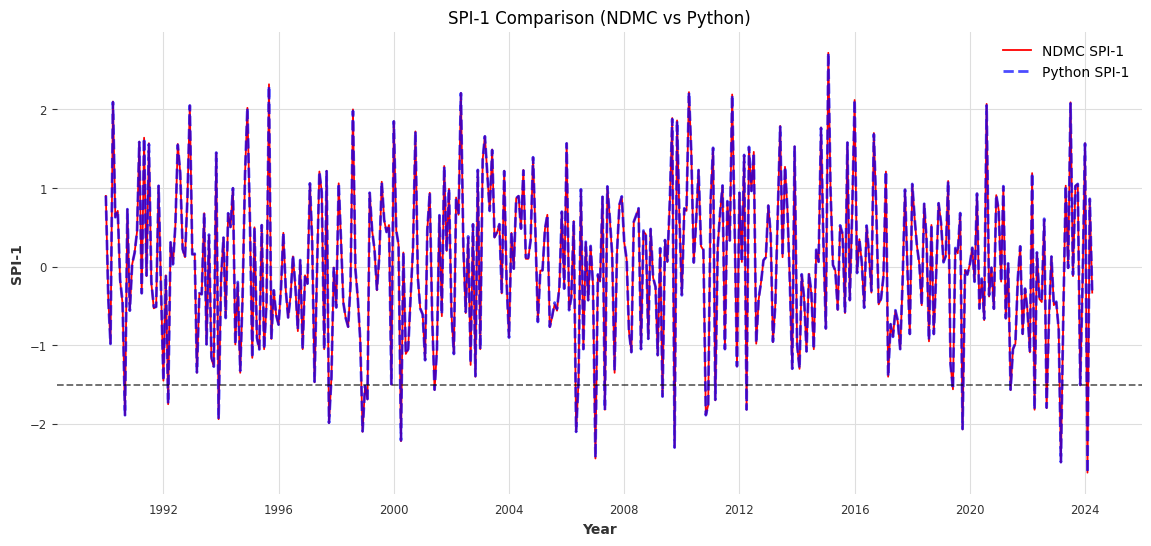

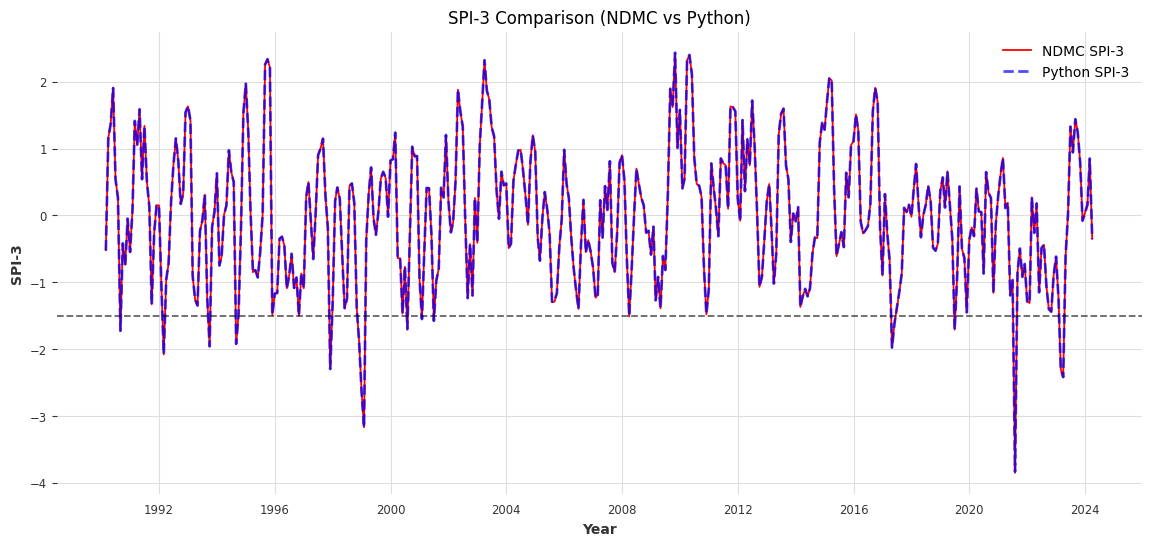

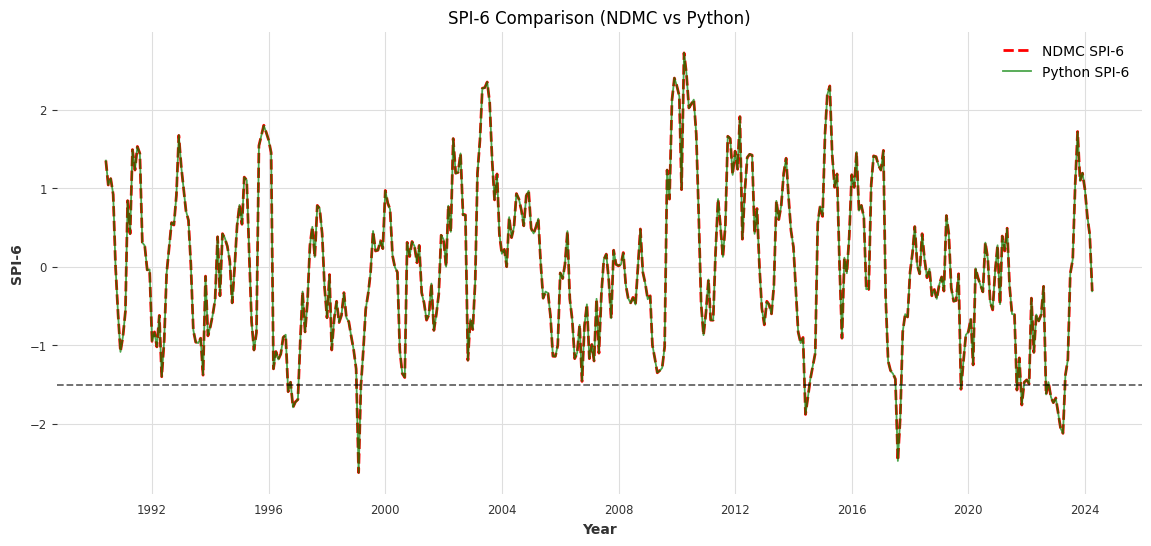

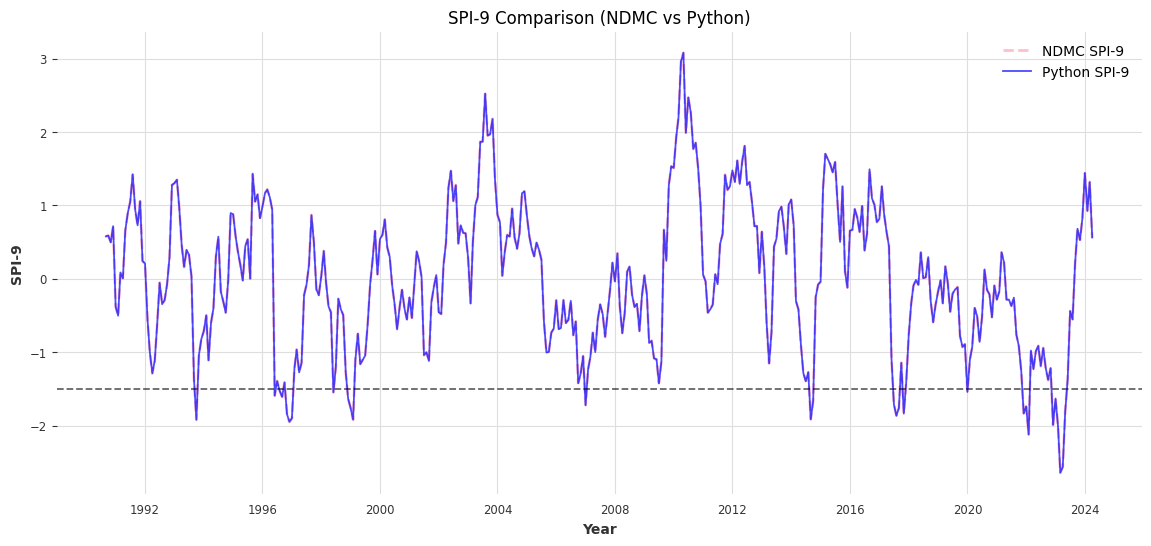

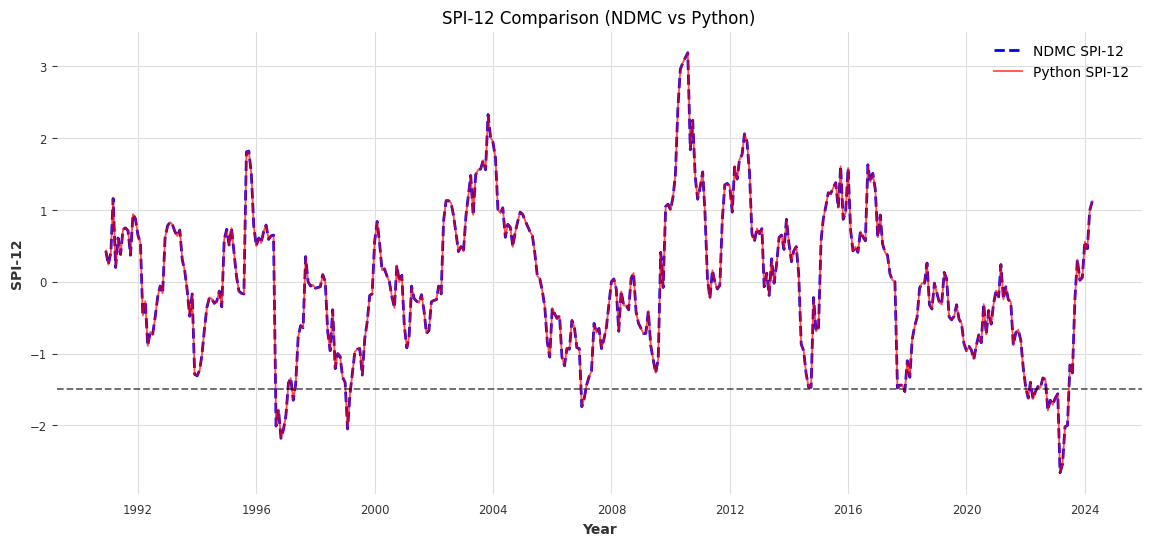

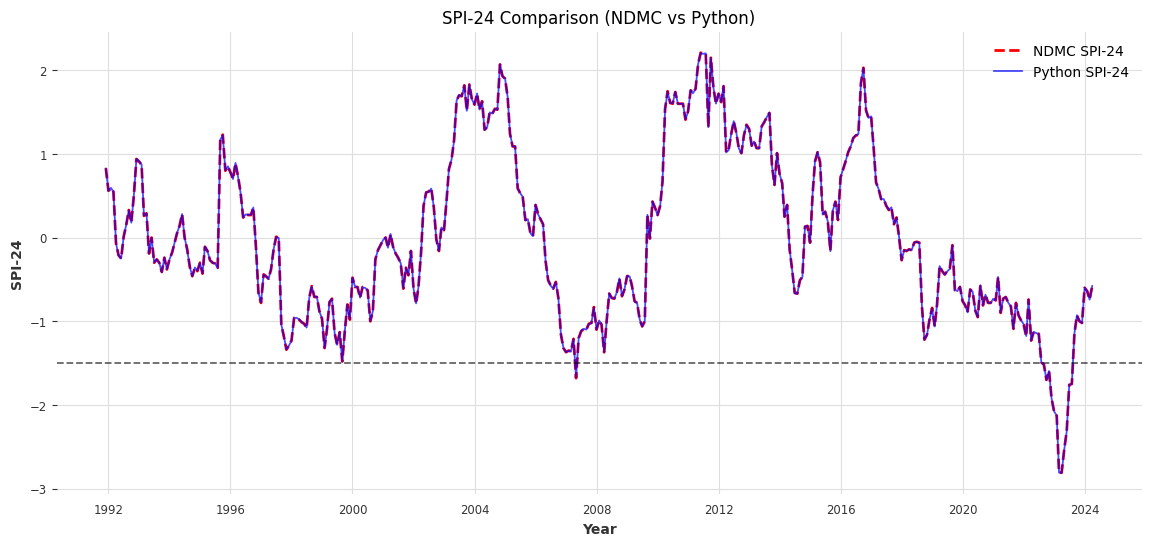

SPI-1 correlation: 0.9999784414000351
SPI-3 correlation: 0.999994915510543


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load NDMC SPI output ---
ndmc = pd.read_csv(r'C:\Users\varas\Documents\Mine\Codes\PredictionDroughtUsingLSTM-\Data\ndmc_spis\40700_SPI_M_01_03_06_09_12_24.csv', skiprows=1)
ndmc["date"] = pd.to_datetime(ndmc["date"], format="%m/%d/%Y")

# Keep only SPI1 and SPI3 for comparison (you can add more)
ndmc.columns = ndmc.columns.str.strip().str.lower().str.replace('"', '')
# ndmc = ndmc[["date", "spi1", "spi3"]].astype(float)

ndmc = ndmc[["date", "spi1", "spi3","spi6","spi9","spi12","spi24"]]

# Strip quotes and whitespace from all SPI columns
for col in ["spi1", "spi3","spi6","spi9","spi12","spi24"]:
    ndmc[col] = ndmc[col].astype(str).str.replace('"', '').str.strip().astype(float)
    ndmc[col] = ndmc[col].replace(-99, np.nan)


# ndmc[["spi1", "spi3"]] = ndmc[["spi1", "spi3"]].astype(float)

# --- Load your Python SPI output ---
py_spi = pd.read_csv(r"C:\Users\varas\Documents\Mine\Codes\PredictionDroughtUsingLSTM-\Data\python_spi\40700_SPI.csv")  # replace with your filename
py_spi["ds"] = pd.to_datetime(py_spi["ds"])

# Align columns
comparison = pd.merge(ndmc, py_spi, left_on="date", right_on="ds", how="inner")

# --- Plot SPI-1 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi1"], label="NDMC SPI-1", color="red")
plt.plot(comparison["date"], comparison["SPI_1"], label="Python SPI-1", color="blue", alpha=0.7, linestyle="--", linewidth=2)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-1 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-1")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot SPI-3 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi3"], label="NDMC SPI-3", color="red")
plt.plot(comparison["date"], comparison["SPI_3"], label="Python SPI-3", color="blue", alpha=0.7, linestyle="--", linewidth=2)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-3 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-3")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot SPI-6 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi6"], label="NDMC SPI-6", color="red", linestyle="--", linewidth=2)
plt.plot(comparison["date"], comparison["SPI_6"], label="Python SPI-6", color="green", alpha=0.7)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-6 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-6")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot SPI-9 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi9"], label="NDMC SPI-9", color="pink", linestyle="--", linewidth=2)
plt.plot(comparison["date"], comparison["SPI_9"], label="Python SPI-9", color="blue", alpha=0.7)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-9 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-9")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot SPI-12 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi12"], label="NDMC SPI-12", color="blue", linestyle="--", linewidth=2)
plt.plot(comparison["date"], comparison["SPI_12"], label="Python SPI-12", color="red", alpha=0.7)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-12 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-12")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot SPI-24 comparison ---
plt.figure(figsize=(14,6))
plt.plot(comparison["date"], comparison["spi24"], label="NDMC SPI-24", color="red", linestyle="--", linewidth=2)
plt.plot(comparison["date"], comparison["SPI_24"], label="Python SPI-24", color="blue", alpha=0.7)
plt.axhline(-1.5, linestyle="--", color="black", alpha=0.6)
plt.title("SPI-24 Comparison (NDMC vs Python)")
plt.xlabel("Year")
plt.ylabel("SPI-24")
plt.legend()
plt.grid(True)
plt.show()
# --- Optional: calculate correlation ---
print("SPI-1 correlation:", comparison[["spi1", "SPI_1"]].corr().iloc[0,1])
print("SPI-3 correlation:", comparison[["spi3", "SPI_3"]].corr().iloc[0,1])


class TaylorDiagram

In [9]:

class TaylorDiagram:
    def __init__(self, ref_std, fig=None, rect=111, label='Reference'):
        self.ref_std = ref_std
        self.sample_points = []

        self.fig = fig if fig is not None else plt.figure(figsize=(8, 6))
        self.ax = self.fig.add_subplot(rect, polar=True)

        # Configure polar axes
        self.ax.set_theta_zero_location('E')

        self.ax.set_theta_direction(-1)
        self.ax.set_theta_offset(np.pi / 2)
        self.ax.set_ylim(0, 1.5 * ref_std)
        self.ax.set_thetamin(0)
        self.ax.set_thetamax(90)

        # Set up correlation coefficient grid
        self._setup_axes()

        # Plot reference point
        self.ax.plot([0], [ref_std], 'k*', markersize=12, label=label)

    def _setup_axes(self):
        corrs = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0])
        angles = np.arccos(corrs)

        self.ax.set_thetagrids(np.degrees(angles), labels=[f"{c:.2f}" for c in corrs], fontsize=10)
        self.ax.set_rlabel_position(135)
        self.ax.set_ylabel('Standard Deviation', fontsize=12)

        # Add radial grid lines manually
        for angle in angles:
            self.ax.plot([angle, angle], [0, self.ax.get_ylim()[1]], color='lightgray', linestyle='--', linewidth=0.5)

    def add_sample(self, stddev, corrcoef, label, marker='o', color=None):
        theta = np.arccos(corrcoef)
        point, = self.ax.plot(theta, stddev, marker=marker, label=label, color=color, markersize=8)
        self.sample_points.append(point)

    def add_contours(self, levels=6, cmap='coolwarm', linewidths=1.2):
        rs, ts = np.meshgrid(
            np.linspace(0, self.ax.get_ylim()[1], 300),
            np.linspace(0, np.pi / 2, 300)
        )
        rms = np.sqrt(
            self.ref_std**2 + rs**2 - 2 * self.ref_std * rs * np.cos(ts)
        )
        contours = self.ax.contour(
            ts, rs, rms,
            levels=np.linspace(0, self.ax.get_ylim()[1], levels),
            cmap=cmap,
            linewidths=linewidths
        )
        self.fig.colorbar(contours, ax=self.ax, pad=0.1, orientation='vertical', label="RMS Difference")
        return contours

    def show(self, title='Taylor Diagram'):
        self.ax.set_title(title, fontsize=14, pad=20)
        self.ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()


Define Models and train


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.



=== Station 40708 | SPI_6 ===
!!!@@@------Training LSTM…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 44.4 K | train
6 | V               | Linear           | 61     | train
-------------------------------------------------------------
44.5 K    Trainable params
0         Non-trainable params
44.5 K    Total params
0.178     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:00<00:00, 31.47it/s, train_loss=0.0625]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 22/22 [00:00<00:00, 31.47it/s, train_loss=0.0625]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


 saved.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]
0.10585037298759607
RMSE: 1.7158784412341086
MAE : 1.069517406861157
R²  : -0.230901181999684
sMAPE: 136.49978881563234
(1.180678526123545, 0.6663266887604579, 0.10585037298759607, 1.3099154328559186, 1.069517406861157, 136.49978881563234)


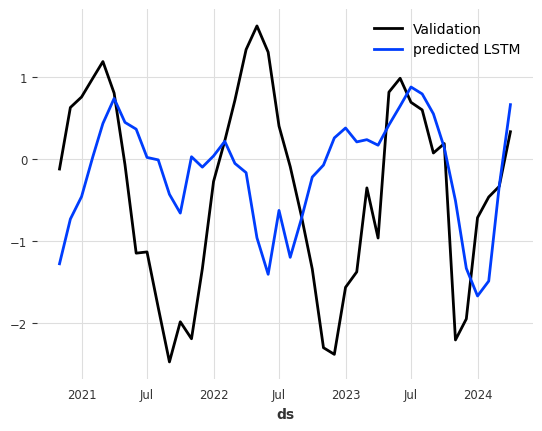

In [45]:

class WBBLSTMModel:
    def __init__(self, wavelet='db1', level=1, **lstm_kwargs):
        self.wavelet = wavelet
        self.level = level
        self.lstm_kwargs = lstm_kwargs
        self.lstm_model = RNNModel(model='LSTM', **lstm_kwargs)
        
    def wavelet_decompose(self, series: TimeSeries):
        coeffs = pywt.wavedec(series.values().flatten(), self.wavelet, level=self.level)
        return coeffs
    
    def wavelet_reconstruct(self, coeffs):
        return pywt.waverec(coeffs, self.wavelet)
    
    def fit(self, series: TimeSeries):
        # Decompose
        coeffs = self.wavelet_decompose(series)
        approx = coeffs[0]  # Use approximation coeffs as input to LSTM
        approx_series = TimeSeries.from_values(approx.reshape(-1, 1))
        
        # Fit the internal LSTM model
        self.lstm_model.fit(approx_series)

    def predict(self, n,series):
        # 1) Decompose historical series into coeffs
        hist_coeffs = self.wavelet_decompose(series)
        hist_approx, *hist_details = hist_coeffs

        # 2) Forecast only the approximation coeffs (with correct time index)
        approx_ts = self.lstm_model.predict(n, series=series)
        approx_pred = approx_ts.values().flatten()

        # 3) Build a new approximation array: [historic approx | predicted approx]
        full_approx = np.concatenate([hist_approx, approx_pred])


        dummy_signal = np.zeros_like(approx_pred)

        # 2. Decompose dummy to get the correct coeff shapes
        dummy_coeffs = pywt.wavedec(dummy_signal, self.wavelet, level=self.level)

        full_coeffs   = [full_approx] + [np.zeros_like(c) for c in dummy_coeffs[1:]]
        print("Full approx length:", len(full_approx))
        print("Expected shapes:")
        for i, c in enumerate(dummy_coeffs):
            print(f"  Coeff {i}: shape = {c.shape}")

        print("\nYour full_coeffs shapes:")
        for i, c in enumerate(full_coeffs):
                print(f"  Coeff {i}: shape = {c.shape}")

        

        # 3. Replace only the *approximation level* with your forecast (but RESHAPED to the correct length)
        approx_pred_downsampled = pywt.wavedec(approx_pred, self.wavelet, level=self.level)[0]

        # 4. Now use it with the correct detail coeff shapes
        coeffs = [approx_pred_downsampled] + [np.zeros_like(c) for c in dummy_coeffs[1:]]

        # 5. Reconstruct
        full_series = self.wavelet_reconstruct(coeffs)

        # 5) zero out all detail levels (you could also keep hist_details if you want)

        # # 6) reconstruct the full signal
        # full_series   = self.wavelet_reconstruct(full_coeffs)

        # 7) extract just the last n points (the forecast window)
        forecast_vals = full_series[-n:]

        # 8) wrap back into TimeSeries with the right ds index
        return TimeSeries.from_times_and_values(
            approx_ts.time_index,
            forecast_vals.reshape(-1, 1),
            columns=approx_ts.components
        )
    def save(self, path):
        # os.makedirs(path, exist_ok=True)

        # Save LSTM model
        self.lstm_model.save(path)

        # Save wavelet settings and kwargs
        meta = {
        'wavelet': self.wavelet,
            'level': self.level,
            'lstm_kwargs': self.lstm_kwargs
        }

        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "r") as f:
            meta = json.load(f)


        wavelet = meta['wavelet']
        level = meta['level']
        lstm_kwargs = meta['lstm_kwargs']
        instance = cls(wavelet=wavelet, level=level, **lstm_kwargs)

        # instance = cls(**meta)
        instance.lstm_model = RNNModel.load(path)
        return instance



window_size = 24
num_epochs=100
horizon = 1 


model_constructors = {
    #    'ExtraTF': lambda: XGBModel(
    #      lags=window_size,
    #      output_chunk_length=horizon,
    #      random_state=SEED,
    #      objective='reg:squarederror'
    # ),
    # 'RandomRF': lambda: RandomForest(
    #      lags=window_size,
    #      output_chunk_length=horizon,
    #      n_estimators=200,
    #      criterion="absolute_error",
    #      random_state=SEED
    # ),
    # 'SVR': lambda: RegressionModel(
    #      model=SVR(kernel='rbf'),
    #      lags=window_size,
    #      output_chunk_length=horizon
    # ),
    'LSTM': lambda: RNNModel(
         model='LSTM',
         input_chunk_length=window_size,
        #  training_length=20,
         output_chunk_length=horizon,
         hidden_dim=60,
         n_rnn_layers=2,
         dropout=0.1,
         batch_size=16,
         n_epochs=num_epochs,
         optimizer_kwargs={'lr':1e-3},
         random_state=SEED,
        #  log_tensorboard=True
    )
    # ,
    # 'naive' : NaiveDrift()
    # ,
    # 'WBBLSTM'   : lambda: WBBLSTMModel(
    #     wavelet='db1',
    #     level=1,
    #     input_chunk_length=window_size,
    #     output_chunk_length=horizon,
    #     hidden_dim=25,
    #     n_rnn_layers=2,
    #     dropout=0.1,
    #     batch_size=16,
    #     n_epochs=num_epochs,
    #     optimizer_kwargs={'lr':1e-3},
    #     random_state=SEED
    # )
}

results = {}  
base_dir = "results"
os.makedirs(base_dir, exist_ok=True)
# listofcols = ['SPI_1','SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']
listofStaion = [40708]
listofcols = ['SPI_6']


for station_id, group in all_spi.groupby('station_id'):
    results[station_id] = {}
    if station_id not in listofStaion:
             continue
    for col in [c for c in group.columns if c.startswith("SPI_")]:
        if col not in listofcols:
            continue
        print(f"\n=== Station {station_id} | {col} ===")
        sub_df = group[['ds', col]].dropna()

        series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)
        # ts_values = series.pd_dataframe().values.flatten()

        # fig, ax = plt.subplots(2, 1, figsize=(8, 6))
        # plot_acf(ts_values, lags=36, ax=ax[0])
        # ax[0].set_title("ACF (up to lag 36)")
        # plot_pacf(ts_values, lags=36, ax=ax[1])
        # ax[1].set_title("PACF (up to lag 36)")
        # plt.tight_layout()
        # plt.show()
        # series_deseasonalized = remove_seasonality(series, seasonality_period=12)  # monthly seasonality
        # plot_acf(series, max_lag=36)
        train, val = series.split_before(0.9)
        # plot_acf(train, m=12, alpha=0.05, max_lag=24)
        # for m in range(2, 25):
        #     is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
        #     if is_seasonal:
        #         print(f"There is seasonality of order {period}.")
        val.plot(label="Validation",title=f"Station {station_id} | {col} → Val vs Prediction")

        
        val_s.plot(label="org")

        model_folder = os.path.join(base_dir, f"{station_id}/{col}")
        os.makedirs(model_folder, exist_ok=True)

        model_constructors = {
            # 'ExtraTF': lambda: XGBModel(
            #     lags=periodicity,
            #     output_chunk_length=3,
            #     n_estimators=300,

            #     random_state=SEED,
            #     objective='reg:squarederror'
            # ),
            'RandomRF': lambda: RandomForest(
                lags=3*periodicity,
                output_chunk_length=80,
                n_estimators=600,
                criterion="absolute_error",
                random_state=SEED,
                # max_depth=10,
                max_depth=20,
                min_samples_split=10,
                min_samples_leaf=1,
                min_weight_fraction_leaf=0.0,
                min_impurity_decrease=0.0,
                # min_samples_leaf=3,
            ),
            # 'SVR': lambda: RegressionModel(
            #     model=SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'),
            #     lags=periodicity,
            #     output_chunk_length=3
            # ),
            # 'LSTM': lambda: RNNModel(
            #     model='LSTM',
            #     input_chunk_length=periodicity,
            #     #  output_chunk_length=horizon,
            #     hidden_dim=20,
            #     #  n_rnn_layers=6,
            #     training_length=80,

            #     dropout=0,
            #     batch_size=16,
            #     n_epochs=500,
            #     optimizer_kwargs={'lr':1e-3},
            #     random_state=SEED,
            #     force_reset=True
            # ),
            # 'WBBLSTM'   : lambda: WBBLSTMModel(
            #     wavelet='db1',
            #     level=1,
            #     input_chunk_length=periodicity,
            #     # output_chunk_length=horizon,
            #     hidden_dim=20,
            #     # n_rnn_layers=6,
            #     dropout=0,
            #     batch_size=16,
            #     n_epochs=500,
            #     optimizer_kwargs={'lr':1e-3},
            #     random_state=SEED,
            #     force_reset=True
            # )
        }

        model_stats = {}
        forecasts = {}
        for name, mk in model_constructors.items():
            model_path = os.path.join(model_folder, name)
            if os.path.exists(model_path):
                print(f"Model {name} already trained. Skipping.")
                model_class = {
                    'LSTM': RNNModel,
                    'SVR': RegressionModel,
                    'RandomRF': RandomForest,
                    'ExtraTF': XGBModel,
                    'WBBLSTM': WBBLSTMModel
                    # ,
                    # 'naive' :NaiveDrift
                }[name]
                print(f"!!!@@@-----Loading {name} model from {model_path}…")
                model = model_class.load(model_path)

            else:
                print(f"!!!@@@------Training {name}…", end='')
                model = mk()

                model.fit(series=train)
                model.save(model_path)

                print(" saved.")
            fc = model.predict(len(val), series=train)

            o = val.values().flatten()
            p = fc.values().flatten()
            fc.plot(label=f"predicted {name}")
            corr = pearsonr(o, p)[0]
            print(corr)
            print("RMSE:", mean_squared_error(o, p))
            print("MAE :", mean_absolute_error(o, p))
            print("R²  :", r2_score(o, p))
            print("sMAPE:", np.mean(2 * np.abs(o - p) / (np.abs(o) + np.abs(p))) * 100)

            if corr < 0:
                print('negative corr -red flag')


            rm   = np.sqrt(mean_squared_error(o, p))
            mae_v= mean_absolute_error(o, p)
            sm   = np.mean(2 * np.abs(o-p) / (np.abs(o)+np.abs(p))) * 100

            model_stats[name] = (np.std(o), np.std(p), corr, rm, mae_v, sm)
            forecasts[name] = fc
            print(model_stats[name])


            

        results[station_id][col] = model_stats




Loop over stations & timescales, 
 forecast

1.00 ,std_p: 0.70, corr: 0.12, rmse: 1.16, mae_v: 0.92,sm: 132.37 - LSTM 


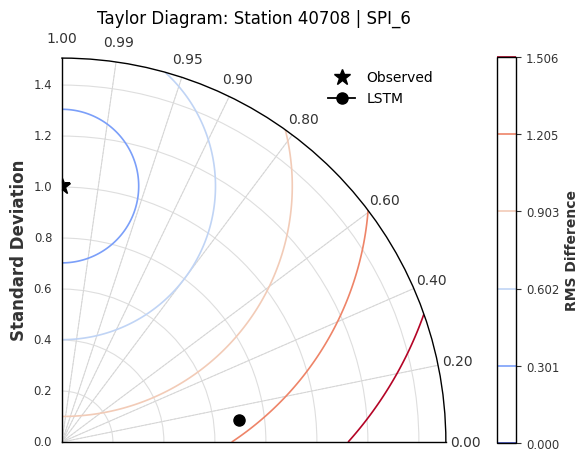

Best model1 for 40708 | SPI_6: WBBLSTM
Best model2 for 40708 | SPI_6: SVR
Best model3 for 40708 | SPI_6: SVR
Best model4 for 40708 | SPI_6: WBBLSTM


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 132 K  | train
6 | V               | Linear           | 61     | train
-------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.529     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 24/24 [00:01<00:00, 16.70it/s, train_loss=0.0637]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 99: 100%|██████████| 24/24 [00:01<00:00, 16.54it/s, train_loss=0.0637]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


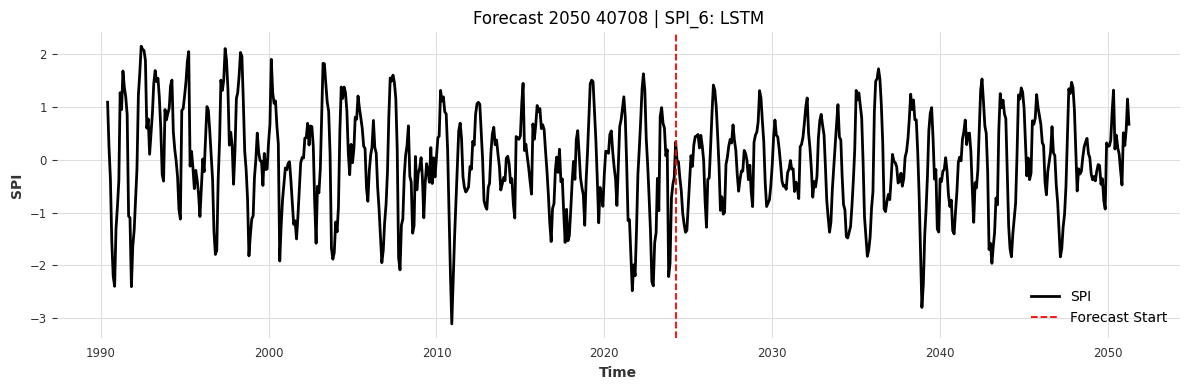

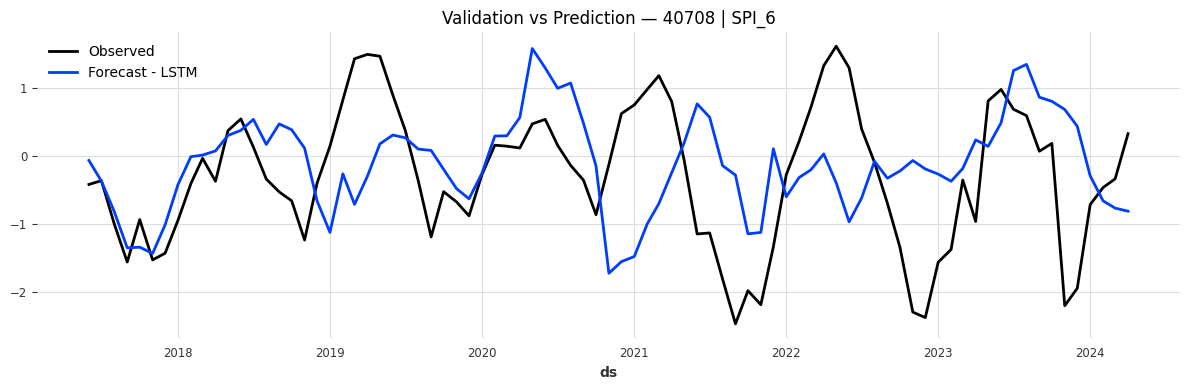

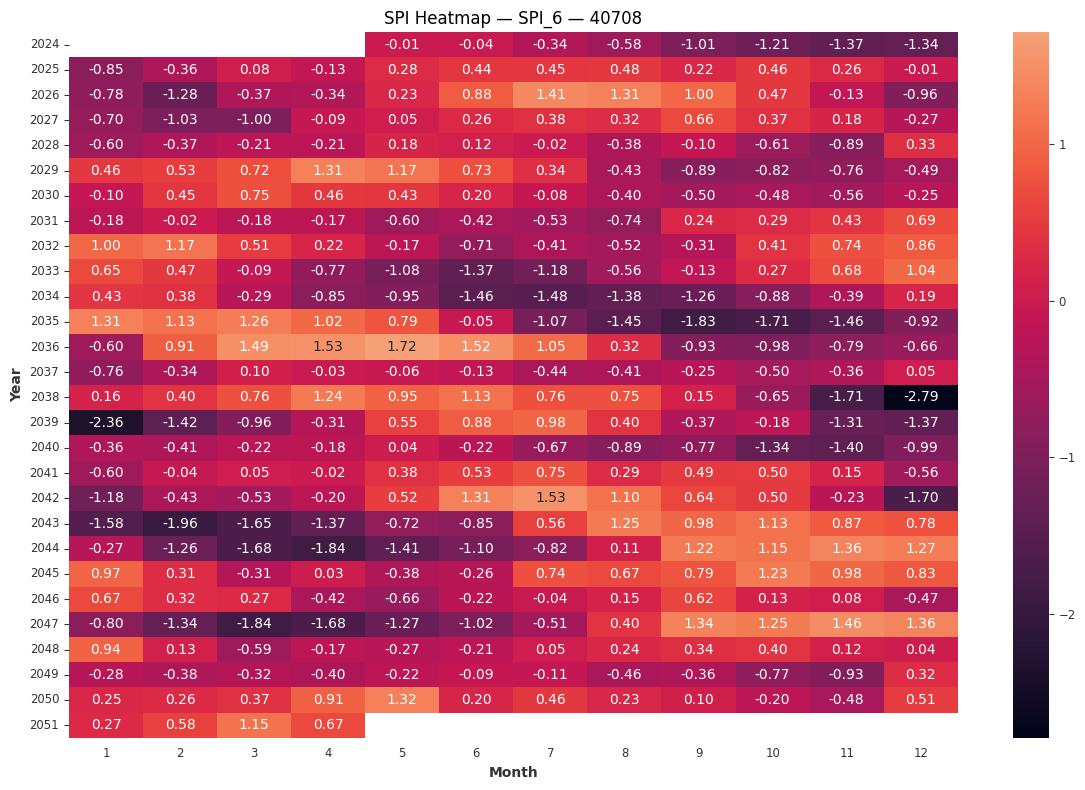

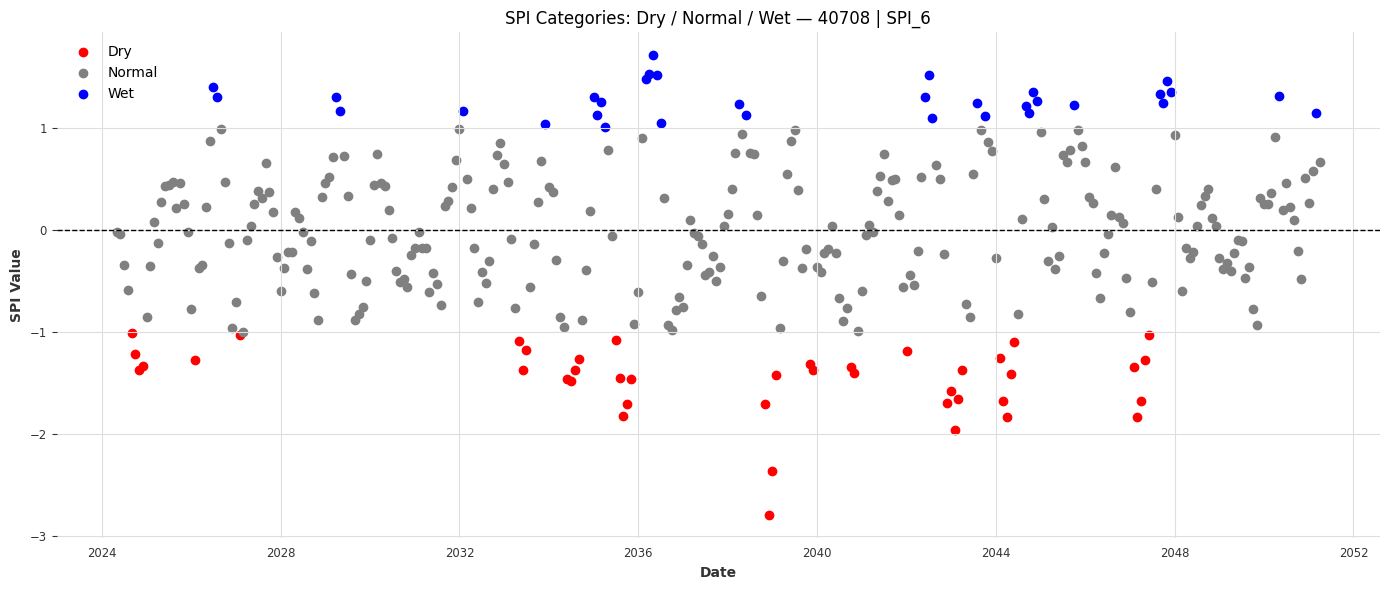

In [10]:
def model_score(stats):
    std_o, std_p, corr, rmse, mae, _ = stats
    std_diff = abs(std_o - std_p)
    return 0.5 * rmse + 0.3 * mae + 0.1 * std_diff - 0.1 * corr  

# listofStaion = [88107]
# listofcols = ['SPI_1','SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']

for station_id, group in all_spi.groupby('station_id'):
    if station_id not in listofStaion:
             continue
    for col in [c for c in group.columns if c.startswith("SPI_")]:
            if col not in listofcols:
                continue
            model_stats = results[station_id][col]  
            sub_df = group[['ds', col]].dropna()

            series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)


            # Taylor Diagram
            ref_std = list(model_stats.values())[0][0]
            fig = plt.figure(figsize=(6, 6))
            taylor = TaylorDiagram(ref_std, fig, label='Observed')
            for name, (std_o, std_p, corr, rmse,mae_v,sm) in model_stats.items():
                if corr < 0:
                    print('negative corr')
                    p = -p
                    corr = -corr
                print(f"{std_o:0.2f} ,std_p: {std_p:.2f}, corr: {corr:.2f}, rmse: {rmse:.2f}, mae_v: {mae_v:.2f},sm: {sm:.2f} - {name} ")
                if np.isnan(std_p) or np.isnan(corr) or std_p == 0:
                    print(f"⚠️ Skipping {name} due to invalid metrics.")
                    continue
                taylor.add_sample(std_p, corr, label=name)
            taylor.add_contours()
            plt.legend()
            plt.title(f"Taylor Diagram: Station {station_id} | {col}")
            plt.tight_layout()
            fig.savefig(os.path.join(base_dir, f"{station_id}/taylor_{col}.png"))
            plt.show()

            # Best model


            best_model = min(model_stats.items(), key=lambda x: model_score(x[1]))[0]
            best_model2 = min(model_stats.items(), key=lambda x: x[1][3])[0]
            best_model3 = min(model_stats.items(), key=lambda x: x[1][3])[0]

            # best_model = min(model_stats.items(), key=lambda x: x[1][4])[0]  # MAPE

            print(f"Best model1 for {station_id} | {col}: {best_model}")
            print(f"Best model2 for {station_id} | {col}: {best_model2}")
            print(f"Best model3 for {station_id} | {col}: {best_model3}")
            print(f"Best model4 for {station_id} | {col}: {best_model}")
            best = model_constructors[best_model]()
           
            best.fit(series)

            

            # # Forecast to 2050
            horizon = (pd.Timestamp("2050-12-01") - series.end_time()).days // 30
            future = best.predict(horizon, series=series)


            if not isinstance(future.time_index, pd.DatetimeIndex):
                future = TimeSeries.from_times_and_values(
                    pd.date_range(
                        start=series.end_time() + pd.DateOffset(months=1),
                        periods=len(future),
                        freq="MS"
                    ),
                    future.values(),
                    columns=series.components
                )

            historical = series
            full_series = historical.append(future)

            plt.figure(figsize=(12, 4))
            full_series.plot(label="SPI")
            plt.axvline(x=historical.end_time(), color='r', linestyle='--', label="Forecast Start")
            plt.title(f"Forecast 2050 {station_id} | {col}: {best_model}")

            plt.xlabel("Time")
            plt.ylabel("SPI")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(base_dir, f"{station_id}/Forecast_{col}.png"))

            plt.show()

            # Plot val vs forecast
            # for best_model in model_stats.items():
            _, val = series.split_before(0.8)
            time_idx = val.time_index
            pred = forecasts[best_model]
            val_df  = val.to_dataframe()   # gives you a DataFrame with a DatetimeIndex
            pred_df = pred.to_dataframe()
            plt.figure(figsize=(12, 4))
            val.plot(label="Observed")
            pred.plot(label=f"Forecast - {best_model}")
            plt.title(f"Validation vs Prediction — {station_id} | {col}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(base_dir, f"{station_id}/val_vs_pred_{col}.png"))
            plt.show()


            spi_df = future.pd_dataframe().reset_index()

            spi_df['year'] = pd.to_datetime(spi_df['ds']).dt.year
            spi_df['month'] = pd.to_datetime(spi_df['ds']).dt.month

            # SPI heatmap
            heatmap_data = spi_df.pivot_table(index='year', columns='month', values=col)
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, cmap='rocket', center=0, annot=True, fmt=".2f")
            plt.title(f"SPI Heatmap — {col} — {station_id}")
            plt.xlabel("Month")
            plt.ylabel("Year")
            plt.tight_layout()
            plt.grid(False)
            plt.savefig(os.path.join(base_dir, f"{station_id}/heatmap_{col}.png"))
            plt.show()

            spi_df['category'] = pd.cut(spi_df[col], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])
            colors = {'Dry': 'red', 'Normal': 'gray', 'Wet': 'blue'}

            plt.figure(figsize=(14, 6))
            for category, color in colors.items():
                mask = spi_df['category'] == category
                plt.scatter(spi_df['ds'][mask], spi_df[col][mask], c=color, label=category)

            plt.axhline(0, color='black', lw=1, linestyle='--')
            plt.title(f"SPI Categories: Dry / Normal / Wet — {station_id} | {col}")
            plt.xlabel("Date")
            plt.ylabel("SPI Value")
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.savefig(os.path.join(base_dir, f"{station_id}/scatter_{col}.png"))
            plt.show()


            # # Use a simple threshold detector
            # detector = ThresholdAD(low_threshold=-1.5, high_threshold=1.5)
            # anomalies = detector.detect(full_series)

            # # Plot
            # full_series.plot(label="SPI")
            # anomalies.plot(label="Anomalies", color='red', marker='o')
            # plt.legend()
            # plt.title(f"Darts Anomaly Detection — {station_id} | {col}")
            # plt.show()

            # print(f"✔️ Done with {station_id} | {col}\n")


then auto slide creation or pdf

In [9]:
ppt_path = os.path.join(base_dir, "SPI_Results_Summary.pptx")
prs = Presentation()

title_slide_layout = prs.slide_layouts[0]
blank_slide_layout = prs.slide_layouts[6]

# Title slide
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "SPI Forecast & Evaluation Summary"
# slide.placeholders[1].text = "Auto-generated using python-pptx\nIncludes Taylor Diagrams, Heatmaps, Model Metrics & Forecasts"

# image_summaries = {
#     "val_vs_pred": "Comparison of predicted vs. actual SPI values. Good alignment indicates accurate forecasting.",
#     "heatmap": "Heatmap of forecast performance over time. Brighter regions indicate higher error or uncertainty.",
#     "taylor": "Taylor diagram summarizing model skill. Closer proximity to reference indicates better performance.",
#     "scatter": "Scatter plot of predicted vs. observed SPI. Closer points to diagonal line show better predictions."
# }

def generate_summary(img_type, model_metrics):
    """Create a smart summary based on image type and model metrics."""
    if not model_metrics:
        return "Performance data not available."

    # Pick the best model based on RMSE (you can use another metric too)
    best_model, (std_o, std_p, corr, rmse, mape,sm) = min(model_metrics.items(), key=lambda x: x[1][3])  # sort by RMSE

    # Interpret performance
    if rmse < 0.3 and mape < 10 and corr > 0.85:
        perf = "excellent"
    elif rmse < 0.6 and mape < 20 and corr > 0.65:
        perf = "reasonable"
    else:
        perf = "poor"

    # Now create summaries
    if img_type == "val_vs_pred":
        return f"Predicted vs. observed SPI using {best_model}. Alignment is {perf}, with RMSE={rmse:.2f}, Corr={corr:.2f}."
    elif img_type == "heatmap":
        return f"Heatmap of error over time for {best_model}. Performance is {perf}, with average MAPE={mape:.1f}%."
    elif img_type == "taylor":
        return f"Taylor diagram showing model spread vs. observed. {best_model} shows {perf} alignment with reference point."
    elif img_type == "scatter":
        return f"Scatter plot for {best_model}. {perf.capitalize()} correlation between predictions and observations (Corr={corr:.2f})."
    else:
        return "Performance visualization."

# Loop through all stations
for station_id in sorted(os.listdir(base_dir)):
    station_path = os.path.join(base_dir, station_id)
    if not os.path.isdir(station_path):
        continue

    for col in results.get(int(station_id), {}):  # Ensure `station_id` matches results keys
        # Add slide for this station/SPI
        slide = prs.slides.add_slide(blank_slide_layout)
        # Add title
        title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        tf = title_box.text_frame
        tf.text = f"Station {station_id} — {col}"
        tf.paragraphs[0].font.size = Pt(24)
        tf.paragraphs[0].font.bold = True

        # Add metrics table
        metrics = results[int(station_id)][col]
        rows, cols = len(metrics) + 1, 6
        table = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1), Inches(8), Inches(0.6 + rows * 0.4)).table
        table.cell(0, 0).text = "Model"
        table.cell(0, 1).text = "RMSE"
        table.cell(0, 2).text = "MAPE"
        table.cell(0, 3).text = "Corr"
        table.cell(0, 4).text = "Std. Dev (Pred)"
        table.cell(0, 5).text = "smape"

        for i, (model_name, (std_o, std_p, corr, rmse, mape,sm)) in enumerate(metrics.items(), start=1):
            table.cell(i, 0).text = model_name
            table.cell(i, 1).text = f"{rmse:.3f}"
            table.cell(i, 2).text = f"{mape:.2f}%"
            table.cell(i, 3).text = f"{corr:.2f}"
            table.cell(i, 4).text = f"{std_p:.2f}"
            table.cell(i, 5).text = f"{sm:.2f}"

        # Add first two images
        # image_files = ["taylor","val_vs_pred",  "heatmap", "scatter"]
        image_files = ["taylor","val_vs_pred","Forecast", "heatmap",  "scatter"]
        img_slide_count = 0
        img_group = []

        for img_type in image_files:
            img_path = os.path.join(station_path, f"{img_type}_{col}.png")
            if not os.path.exists(img_path):
                continue

            # Create a new slide for each image
            current_slide = prs.slides.add_slide(blank_slide_layout)

            # Add slide title
            sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
            sub_tf = sub_title_box.text_frame
            sub_tf.text = f"Station {station_id} — {col} ({img_type.replace('_', ' ').title()})"
            sub_tf.paragraphs[0].font.size = Pt(20)
            sub_tf.paragraphs[0].font.bold = True

            # Add image
            x = Inches(0.5)
            y_img = Inches(1.0)
            current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(8.5))  # Full width if needed

            # Add summary text
            y_text = y_img + Inches(5.8)
            model_metrics = results[int(station_id)][col]
            summary_text = generate_summary(img_type, model_metrics)

            textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(8.5), height=Inches(1))
            tf = textbox.text_frame
            tf.text = summary_text
            tf.paragraphs[0].font.size = Pt(12)

        # for img_type in image_files:
        #     img_path = os.path.join(station_path, f"{img_type}_{col}.png")
        #     if os.path.exists(img_path):
        #         img_group.append(img_path)

        # # Split image group into chunks of 2
        # for i in range(0, len(img_group), 2):
        #     if i == 0:
        #         # Use the first slide already created
        #         current_slide = slide
        #     else:
        #         current_slide = prs.slides.add_slide(blank_slide_layout)

        #         # Add title for extra image slides
        #         sub_title_box = current_slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(9), Inches(0.5))
        #         sub_tf = sub_title_box.text_frame
        #         sub_tf.text = f"Station {station_id} — {col} (Images {i + 1}–{min(i+2, len(img_group))})"
        #         sub_tf.paragraphs[0].font.size = Pt(20)
        #         sub_tf.paragraphs[0].font.bold = True

        #     for j, img_path in enumerate(img_group[i:i+2]):
        #         x = Inches(0.5 + j * 5)  # Side by side
        #         y_img  = Inches(2.7 if i == 0 else 1.0)
        #         y_text = y_img + Inches(3.6)  # Position text below image
        #         current_slide.shapes.add_picture(img_path, x, y_img, width=Inches(4.5))

        #         # Extract image type to get its description
        #         img_filename = os.path.basename(img_path)
        #         img_type = img_filename.split("_")[0]

        #         model_metrics = results[int(station_id)][col]
        #         summary_text = generate_summary(img_type, model_metrics)


        #         textbox = current_slide.shapes.add_textbox(x, y_text, width=Inches(4.5), height=Inches(1))
        #         tf = textbox.text_frame
        #         tf.text = summary_text
        #         tf.paragraphs[0].font.size = Pt(12)

# Save presentation
prs.save(ppt_path)
print(f"✅ Presentation saved to: {ppt_path}")

✅ Presentation saved to: all_results3\SPI_Results_Summary.pptx


Iran Stations Distributions

C:\Users\varas\AppData\Local\Temp\ipykernel_9068\4003667661.py:41: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  iran_shape = iran.unary_union  # In case it's a multi-polygon
C:\Users\varas\AppData\Local\Temp\ipykernel_9068\4003667661.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


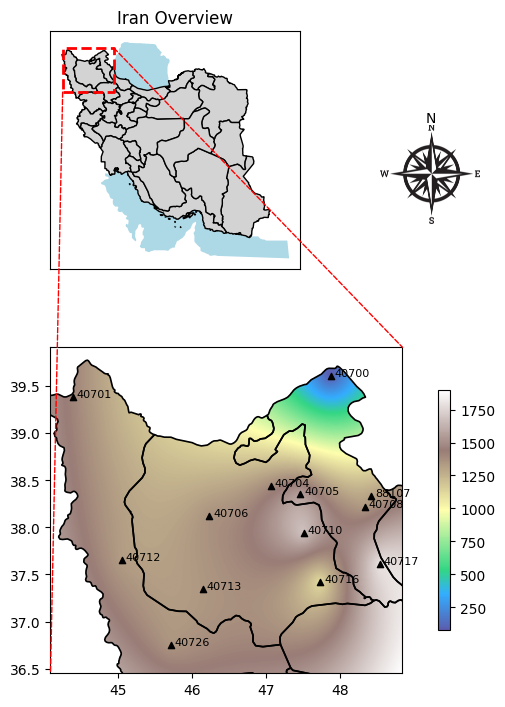

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
from shapely.geometry import Point
import numpy as np
from scipy.interpolate import Rbf
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.path import Path

# === Load shapefiles ===
iran = gpd.read_file('materials/iran.shp')   
sea = gpd.read_file('materials/seas.shp') 

# === Load and prepare station data ===
stations_df = pd.read_csv('../main_data.csv')
stations = stations_df[['station_id', 'station_name', 'station_elevation', 'lat', 'lon']].drop_duplicates()
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry, crs='EPSG:4326')

buffer = 0.3  # Optional: adds margin around stations
xmin, xmax = geo_df.geometry.x.min() - buffer, geo_df.geometry.x.max() + buffer
ymin, ymax = geo_df.geometry.y.min() - buffer, geo_df.geometry.y.max() + buffer


# === Interpolate elevation ===
x = geo_df.geometry.x.values
y = geo_df.geometry.y.values
z = geo_df['station_elevation'].values
grid_res = 500
# xi = np.linspace(iran.total_bounds[0], iran.total_bounds[2], grid_res)
# yi = np.linspace(iran.total_bounds[1], iran.total_bounds[3], grid_res)
xi = np.linspace(xmin, xmax, grid_res)
yi = np.linspace(ymin, ymax, grid_res)
xi, yi = np.meshgrid(xi, yi)
rbf = Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)

# Create a mask from the Iran polygon
iran_shape = iran.unary_union  # In case it's a multi-polygon
mask = np.ones_like(zi, dtype=bool)

# Build a Path object for masking
# iran_path = Path(iran_shape.exterior.coords[:])

# Go through each grid point and mask if it's outside
for i in range(zi.shape[0]):
    for j in range(zi.shape[1]):
        point = (xi[0, j], yi[i, 0])  # Get X, Y of this pixel
        if iran_shape.contains(Point(point)):
            mask[i, j] = False

# Apply mask to elevation
zi_masked = np.ma.masked_array(zi, mask=mask)

# === Define zoom region ===
# # Set the zoom box manually for a region (e.g., Ardabil or any other)
# zoom_xmin, zoom_xmax = 46.5, 49.5
# zoom_ymin, zoom_ymax = 37.0, 39.0

# === Setup figure ===
fig = plt.figure(figsize=(5, 8))

# --- Left: Full map of Iran ---
ax_iran = fig.add_axes([0.02, 0.65, 0.5, 0.5])  # Top-left corner
sea.plot(ax=ax_iran, color='lightblue')
iran.plot(ax=ax_iran, color='lightgray', edgecolor='black')
ax_iran.set_xticks([]); ax_iran.set_yticks([]); ax_iran.set_title('Iran Overview', fontsize=12)

# # Draw zoom rectangle on Iran map
# rect = Rectangle((zoom_xmin, zoom_ymin), zoom_xmax - zoom_xmin, zoom_ymax - zoom_ymin,
#                  linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
# ax_iran.add_patch(rect)

ax_iran.plot([xmin, xmax, xmax, xmin, xmin],
             [ymin, ymin, ymax, ymax, ymin],
             color='red', linestyle='--', linewidth=2)

# --- Right: Zoomed-in elevation with stations ---
ax_zoom = fig.add_axes([0.02, 0.05, 0.8, 0.8])  # Right side

iran.plot(ax=ax_zoom, facecolor='none', edgecolor='black', linewidth=1.2)

elev_img = ax_zoom.imshow(zi_masked, extent=(xi.min(), xi.max(), yi.min(), yi.max()),
                          origin='lower', cmap='terrain', alpha=0.8)

# # Set zoom limits
# ax_zoom.set_xlim(zoom_xmin, zoom_xmax)
# ax_zoom.set_ylim(zoom_ymin, zoom_ymax)

geo_df.plot(ax=ax_zoom, color='black', markersize=20, marker='^', zorder=3)

for idx, row in geo_df.iterrows():
    ax_zoom.text(row.geometry.x + 0.05, row.geometry.y, 
                 str(row['station_id']), fontsize=8, color='black')
# ax_zoom.set_title('Zoomed Region: Elevation & Stations', fontsize=12)
# ax_zoom.set_xticks([]); ax_zoom.set_yticks([])
ax_zoom.set_xlim(xmin, xmax)
ax_zoom.set_ylim(ymin, ymax)
# ax_zoom.set_xticks([]); ax_zoom.set_yticks([])

# --- Colorbar ---
cbar = fig.colorbar(elev_img, ax=ax_zoom, orientation='vertical', pad=0.09, fraction=0.03)
# cbar.set_label('Elevation (m)')

# --- Compass Rose (top right of zoom view) ---
compass_img = mpimg.imread('materials/vecteezy_nautical-compass-icon_.jpg')
ax_compass = fig.add_axes([0.68, 0.77, 0.2, 0.2])  # Adjust position/size here
ax_compass.imshow(compass_img)
ax_compass.axis('off')  # Hide axes frame
ax_compass.set_title("N", fontsize=10, pad=-10)
# imagebox = OffsetImage(compass_img, zoom=0.06)
# ab = AnnotationBbox(imagebox, (0.91, 0.91), xycoords='axes fraction', frameon=False,)
# ax_zoom.add_artist(ab)

# --- Add lines from Iran map to zoomed region ---
# Calculate rectangle corners
corner1 = (xmin, ymin)
corner2 = (xmax, ymax)

# Line from bottom-left corner of zoom box
con1 = ConnectionPatch(xyA=corner1, xyB=corner1, coordsA="data", coordsB="data",
                       axesA=ax_iran, axesB=ax_zoom, color="red", linestyle='--')
fig.add_artist(con1)

# Line from top-right corner of zoom box
con2 = ConnectionPatch(xyA=corner2, xyB=corner2, coordsA="data", coordsB="data",
                       axesA=ax_iran, axesB=ax_zoom, color="red", linestyle='--')
fig.add_artist(con2)

plt.tight_layout()
plt.savefig("iran_stations.png", dpi=600, bbox_inches='tight')
plt.show()



In [1]:
import pandas as pd

# Load the data
df = pd.read_csv("../main_data.csv")

# Group by station and calculate averages
summary = df.groupby(['station_id', 'station_name', 'region_name', 'station_elevation'])[
    ['tm_m', 'tmax_m', 'tmin_m', 'rrr24']
].mean().reset_index()

# Rename columns for clarity
summary.columns = [
    'Station ID', 'Station Name', 'Region', 'Elevation (m)',
    'Avg Temp (°C)', 'Avg Max Temp (°C)', 'Avg Min Temp (°C)', 'Avg Rainfall (mm/month)'
]

# Optional: Export to Excel or Word
summary.to_excel("climate_summary.xlsx", index=False)

# Or, export to Word using python-docx (optional)
from docx import Document

doc = Document()
doc.add_heading('Climate Summary of Stations', 0)

table = doc.add_table(rows=1, cols=len(summary.columns))
table.style = 'Table Grid'

# Add headers
hdr_cells = table.rows[0].cells
for i, column in enumerate(summary.columns):
    hdr_cells[i].text = column

# Add data rows
for _, row in summary.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = str(round(item, 2)) if isinstance(item, float) else str(item)

doc.save("climate_summary.docx")
